# Gaspred v1.0

## First version of the project to predict gasoline prices in Brazil.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score


### Getting data from Jan, 2017 to Dec, 2020. 
### Data Loading...

In [2]:
# These are the datasets where we find gas prices in brazilian gas stations from 2017 to 2020.
# Data are inputed per semester, but the granurality inside is per day.

df1 = pd.read_csv('2017-1-ca.csv', sep='\t', encoding='utf-16', decimal=',')
df2 = pd.read_csv('2017-2-ca.csv', sep='\t', encoding='utf-16', decimal=',')
df3 = pd.read_csv('2018-1-ca.csv', sep='\t', encoding='utf-16', decimal=',')
df4 = pd.read_csv('2018-2-ca.csv', sep='\t', encoding='utf-16', decimal=',')
df5 = pd.read_csv('2019-1-ca.csv', sep='\t', encoding='utf-16', decimal=',')
df6 = pd.read_csv('2019-2-ca.csv', sep=';', encoding='latin1', decimal=',')
df7 = pd.read_csv('2020-1-ca.csv', sep=';', encoding='latin1', decimal=',')
df8 = pd.read_csv('2020-2-ca.csv', sep=';', encoding='latin1', decimal=',')

# These are the datasets where we find the prices of:
# WTI Crude Oil (Oil future prices)
# Dollar (USD/BRL)
# Ethanol (Price of ethanol traded in brazilian stock exchange "B3" (BM&F/Bovespa) - Internal prices)

crude = pd.read_csv('crude.csv')
dollar = pd.read_csv('dollar.csv')
ethanol = pd.read_csv('ethanol.csv')

# These are the datasets where we find importation and exportation of ethanol and oil derivatives

# How much the nation spended importing anhydrous ethanol per month/year
disp_eth_anid = pd.read_csv('dispendio_etanol_anidro.csv', sep = ';', encoding='utf-8')

# How much the nation spended importing hydrous ethanol per month/year
disp_eth_hidr = pd.read_csv('dispendio_etanol_hidratado.csv', sep = ';', encoding='utf-8')

# How much the nation made exporting anhydrous ethanol per month/year
rec_eth_anid = pd.read_csv('receita_etanol_anidro.csv', sep = ';', encoding='utf-8')

# How much the nation made exporting hydrous ethanol per month/year
rec_eth_hidr = pd.read_csv('receita_etanol_hidratado.csv', sep = ';', encoding='utf-8')

# How much the nation spended importing other derivatives (we're focused in gasoline) per month/year
disp_deriv = pd.read_csv('dispendio_derivados.csv', sep=';', encoding='utf-8')

# How much the nation made exporting other derivatives (we're focused in gasoline) per month/year
rec_deriv = pd.read_csv('receita_derivados.csv', sep=';', encoding='utf-8')

### Checking crude, usd_brl, ethanol and gasoline prices datasets...

In [3]:
dollar.head(2)

,Date,Price,Open,High,Low,Change %
0,"Dec 31, 2020",5.1935,5.1940,5.1940,5.1940,-0.00%
1,"Dec 30, 2020",5.1937,5.2051,5.2361,5.1519,-0.31%


In [4]:
crude.head(2)

,Date,Price,Open,High,Low,Vol.,Change %
0,"Dec 31, 2020",48.52,48.35,48.58,47.77,181.89K,0.25%
1,"Dec 30, 2020",48.40,48.13,48.66,47.61,266.96K,0.83%


In [5]:
ethanol.head(2)

,Date,Price,Open,High,Low,Vol.,Change %
0,"Dec 30, 2020","2,105.50","2,059.50","2,068.00","2,055.00",0.03K,0.02%
1,"Dec 29, 2020","2,105.00","2,105.00","2,105.00","2,105.00",0.01K,0.00%


In [6]:
# Taking off the commas in ethanol prices, changing to float and showing it again.

ethanol.Price = ethanol.Price.str.replace(',', '')
ethanol.Price = ethanol.Price.astype(float)
ethanol.head(2)

,Date,Price,Open,High,Low,Vol.,Change %
0,"Dec 30, 2020",2105.5,"2,059.50","2,068.00","2,055.00",0.03K,0.02%
1,"Dec 29, 2020",2105.0,"2,105.00","2,105.00","2,105.00",0.01K,0.00%


In [7]:
df1.head(2)

,Região - Sigla,Estado - Sigla,Município,Revenda,CNPJ da Revenda,Produto,Data da Coleta,Valor de Venda,Valor de Compra,Unidade de Medida,Bandeira
0,CO,DF,BRASILIA,AMORIM COMERCIO DE DERIVADOS DE PETROLEO LTDA,38043832000168,DIESEL,01/02/2017,3.279,NaN,R$ / litro,IPIRANGA
1,CO,DF,BRASILIA,AMORIM COMERCIO DE DERIVADOS DE PETROLEO LTDA,38043832000168,DIESEL,01/03/2017,3.389,2.9383,R$ / litro,IPIRANGA


### Checking incomes and expenses datasets

In [8]:
disp_eth_anid.head(2)

,ANO,PRODUTO,MOVIMENTO COMERCIAL,UNIDADE,JAN,FEV,MAR,ABR,MAI,JUN,JUL,AGO,SET,OUT,NOV,DEZ,TOTAL
0,2012,ETANOL ANIDRO,DISPÊNDIO COM IMPORTAÇÃO,US$ FOB,99415439,95486341,32776201.0,73275765.0,26835789.0,4425082.0,15469938.0,29035009.0,116075.0,51449.0,76628.0,36158.0,376999874
1,2013,ETANOL ANIDRO,DISPÊNDIO COM IMPORTAÇÃO,US$ FOB,9543617,5755180,39799468.0,9664990.0,30655.0,12060811.0,8694268.0,8532.0,47651.0,4758.0,41306.0,4552560.0,90203796


In [9]:
disp_eth_hidr.head(2)

,ANO,PRODUTO,MOVIMENTO COMERCIAL,UNIDADE,JAN,FEV,MAR,ABR,MAI,JUN,JUL,AGO,SET,OUT,NOV,DEZ,TOTAL
0,2012,ETANOL HIDRATADO,DISPÊNDIO COM IMPORTAÇÃO,US$ FOB,261499,51772,281914.0,179240.0,210257.0,154329.0,47534.0,167042.0,91908.0,129953.0,175898.0,27691.0,1779037
1,2013,ETANOL HIDRATADO,DISPÊNDIO COM IMPORTAÇÃO,US$ FOB,197923,280186,336400.0,44494.0,46724.0,35349.0,291655.0,7034.0,126897.0,20239.0,5890.0,32738.0,1425529


In [10]:
rec_eth_anid.head(2)

,ANO,PRODUTO,MOVIMENTO COMERCIAL,UNIDADE,JAN,FEV,MAR,ABR,MAI,JUN,JUL,AGO,SET,OUT,NOV,DEZ,TOTAL
0,2012,ETANOL ANIDRO,RECEITA COM EXPORTAÇÃO,US$ FOB,38608035,36375709,37083572.0,29005781.0,84907064.0,76203056.0,235771947.0,179069921.0,197987630.0,223821597.0,139477497.0,163571473.0,1441883282
1,2013,ETANOL ANIDRO,RECEITA COM EXPORTAÇÃO,US$ FOB,117491306,74421816,33884514.0,62525047.0,77517534.0,125272415.0,166649965.0,256873919.0,113662886.0,109273664.0,40672512.0,16626585.0,1194872163


In [11]:
rec_eth_hidr.head(2)

,ANO,PRODUTO,MOVIMENTO COMERCIAL,UNIDADE,JAN,FEV,MAR,ABR,MAI,JUN,JUL,AGO,SET,OUT,NOV,DEZ,TOTAL
0,2012,ETANOL HIDRATADO,RECEITA COM EXPORTAÇÃO,US$ FOB,17802653,31865994,22724331.0,18469051.0,28326925.0,30486373.0,69010411.0,45034988.0,133183809.0,126395985.0,76932750.0,127670809.0,727904079
1,2013,ETANOL HIDRATADO,RECEITA COM EXPORTAÇÃO,US$ FOB,112792476,62372945,16905926.0,9352508.0,16418738.0,63202079.0,56802975.0,57459830.0,68594765.0,95125205.0,73170699.0,41868958.0,674067104


In [19]:
disp_deriv.head(2)

,ANO,PRODUTO,UNIDADE,JAN,FEV,MAR,ABR,MAI,JUN,JUL,AGO,SET,OUT,NOV,DEZ,TOTAL
0,2000,ASFALTO,US$ FOB,2250,40334.0,22737.0,111153,63576,17715.0,20955.0,30588,36752,55193.0,14551,19653.0,435457
1,2000,PARAFINA,US$ FOB,719978,580677.0,404257.0,511119,563615,848088.0,486333.0,778961,564835,729330.0,349109,358946.0,6895248


In [13]:
rec_deriv.head(2)

,ANO,PRODUTO,UNIDADE,JAN,FEV,MAR,ABR,MAI,JUN,JUL,AGO,SET,OUT,NOV,DEZ,TOTAL
0,2000,GASOLINA DE AVIAÇÃO,US$ FOB,881715,153032,510540.0,28731,0,1329492,398056,150616,1699734.0,1490425.0,405002,249817.0,7297160
1,2000,GASOLINA A,US$ FOB,17694662,272899,42384151.0,99029,27489316,15629763,35360967,71753834,49619966.0,40384444.0,20076542,77930515.0,398696088


In [20]:
def clean_derivatives(dataset, final_column, columns_to_drop=None):

    '''
        This function gets the wide dataframe of import and export of ethanol and other derivatives
        and returns it in a long way so it can bet concatenated in the final dataframe to input 
        in a model.
        
        dataset -> the dataset needed to be clean
        final_column -> the name of the final column, ie the name of the product (ethanol, gasoline, etc.)
        columns_to_drop -> useless columns to be dropped
    
    '''    
    
    values = {}
    
    dataset = dataset.query('ANO >= 2017 and ANO <= 2020')
    
    dataset = dataset.drop(columns_to_drop, axis=1)
    
    dataset = dataset.set_index('ANO')
    
    dataset.columns = [i+1 for i in range(len(dataset.columns))]
    
    for i in dataset.index:
        
        for j in dataset.columns:
            
            for k in range(1, 28):
                
                values[str(k) + '/' + str(j) + '/' + str(i)] = (dataset.at[i, j])
                
    df = pd.DataFrame(index=values.keys(), data=values.values(), columns=final_column)
    
    df.index = pd.to_datetime(df.index, format='%d/%m/%Y')

    return df

In [21]:
rec_eth_hidr = clean_derivatives(rec_eth_hidr, ['hydr_eth_income'], 
                                 ['PRODUTO', 'UNIDADE', 'MOVIMENTO COMERCIAL', 'TOTAL'])

rec_eth_anid = clean_derivatives(rec_eth_anid, ['anid_eth_income'], 
                                 ['PRODUTO', 'UNIDADE', 'MOVIMENTO COMERCIAL', 'TOTAL'])

disp_eth_hidr = clean_derivatives(disp_eth_hidr, ['eth_hidr_exp'], 
                                 ['PRODUTO', 'UNIDADE', 'MOVIMENTO COMERCIAL', 'TOTAL'])

disp_eth_anid = clean_derivatives(disp_eth_anid, ['eth_anid_exp'], 
                                 ['PRODUTO', 'UNIDADE', 'MOVIMENTO COMERCIAL', 'TOTAL'])

disp_deriv = clean_derivatives(disp_deriv.query('PRODUTO == "GASOLINA A"'), 
                                    ['gasoline_exp'], ['PRODUTO', 'UNIDADE', 'TOTAL'])


rec_deriv = clean_derivatives(rec_deriv.query('PRODUTO == "GASOLINA A"'), 
                                    ['gasoline_inc'], ['PRODUTO', 'UNIDADE', 'TOTAL'])

In [22]:
# Merging all features

exp_imp = pd.concat([rec_eth_hidr, 
                     rec_eth_anid, 
                     disp_eth_hidr, 
                     disp_eth_anid, 
                     disp_deriv, 
                     rec_deriv], axis=1)

In [23]:
exp_imp.head()

,hydr_eth_income,anid_eth_income,eth_hidr_exp,eth_anid_exp,gasoline_exp,gasoline_inc
2017-01-01,2167833.0,69372810.0,31680.0,85920169.0,115274214,25701417.0
2017-01-02,2167833.0,69372810.0,31680.0,85920169.0,115274214,25701417.0
2017-01-03,2167833.0,69372810.0,31680.0,85920169.0,115274214,25701417.0
2017-01-04,2167833.0,69372810.0,31680.0,85920169.0,115274214,25701417.0
2017-01-05,2167833.0,69372810.0,31680.0,85920169.0,115274214,25701417.0


#### We've gotta transform the date of crude, ethanol and dollar to specific date in the other dataframes

In [24]:
dollar = dollar[['Date', 'Price']].rename(columns={'Date': 'date', 'Price': 'usd_brl'})
dollar.date = pd.to_datetime(dollar.date, format='%b %d, %Y')

crude = crude[['Date', 'Price']].rename(columns={'Date': 'date', 'Price': 'crude_price'})
crude.date = pd.to_datetime(crude.date, format='%b %d, %Y')

ethanol = ethanol[['Date', 'Price']].rename(columns={'Date': 'date', 'Price': 'ethanol_price'})
ethanol.date = pd.to_datetime(ethanol.date, format='%b %d, %Y')

crude.head(2)

,date,crude_price
0,2020-12-31,48.52
1,2020-12-30,48.40


### Plotting prices to see some inconsistency...

In [25]:
def gen_lineplot(x, y, y_unit='Price US$'):

    ax = plt.figure(figsize=(19,6))

    plt.plot(x, y, linewidth=3);
    plt.yticks(fontsize=14);
    plt.xticks(fontsize=14);
    plt.ylabel(y_unit, fontsize=14)
    
    plt.show()
    plt.close()

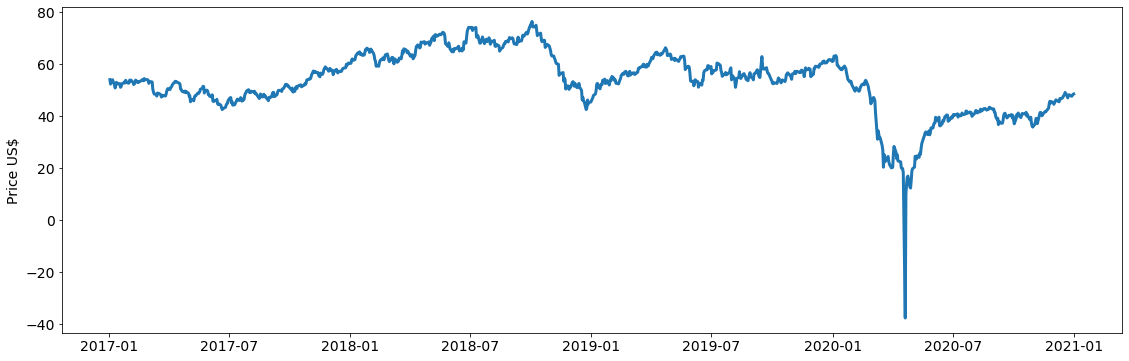

In [26]:
gen_lineplot(crude.date, crude.crude_price)

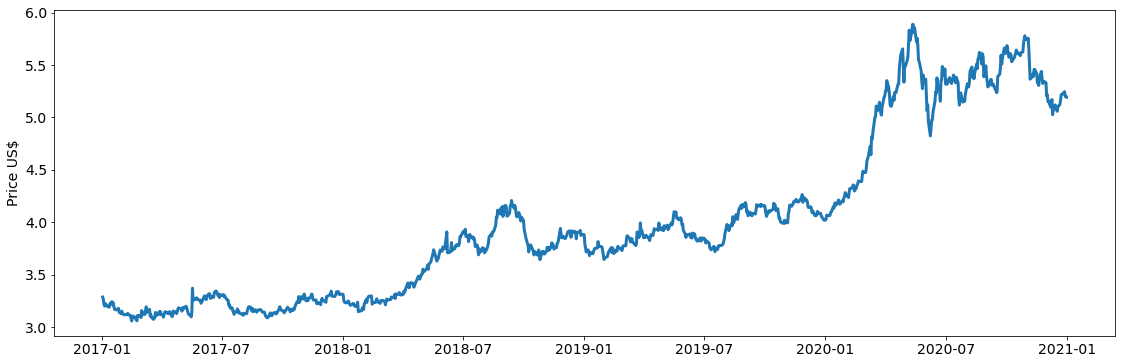

In [27]:
gen_lineplot(dollar.date, dollar.usd_brl)

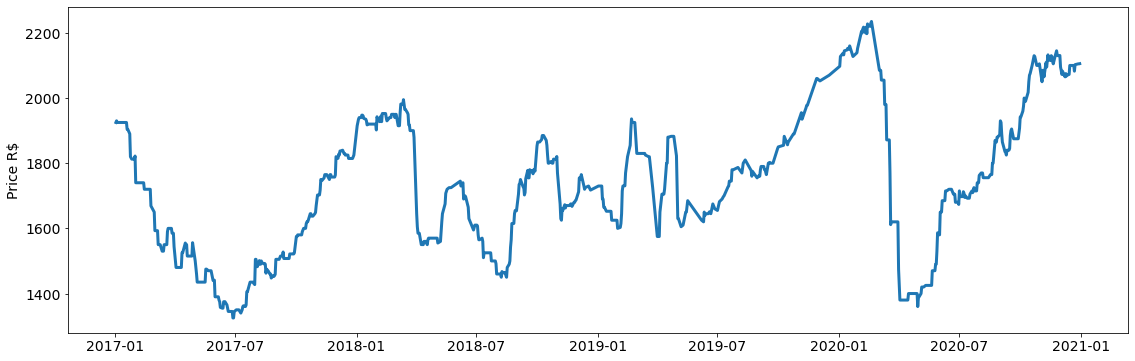

In [28]:
gen_lineplot(ethanol.date, ethanol.ethanol_price, y_unit='Price R$')

### There's negative value in crude prices, so we should ignore that.

In [29]:
crude = crude[crude['crude_price'] > 0]

### Concatenating all years with the target prices...

In [30]:
df = pd.concat([df1, df2, df3, df4, df5, df6, df7, df8])

In [31]:
# Function counting rest registers

def rest_reg(df, act):
    '''
        Count and print the registers of a dataframe
        df -> the dataframe you want to count registers
        act -> teh characteristics of the dataframe
    
    '''
    return print('{} registers in {}.' .format(len(df), act))

In [32]:
rest_reg(df1, '2017 semester 1')
rest_reg(df2, '2017 semester 2')
rest_reg(df3, '2018 semester 1')
rest_reg(df4, '2018 semester 2')
rest_reg(df5, '2019 semester 1')
rest_reg(df6, '2019 semester 2')
rest_reg(df7, '2020 semester 1')
rest_reg(df8, '2020 semester 2')

rest_reg(df, 'total')

487651 registers in 2017 semester 1.
300931 registers in 2017 semester 2.
469801 registers in 2018 semester 1.
492504 registers in 2018 semester 2.
496226 registers in 2019 semester 1.
507299 registers in 2019 semester 2.
496663 registers in 2020 semester 1.
222637 registers in 2020 semester 2.
3473712 registers in total.


### Columns have not friendly names... 

In [33]:
print(df.columns)
print(df.columns.shape[0])

Index(['Região - Sigla', 'Estado - Sigla', 'Município', 'Revenda',
       'CNPJ da Revenda', 'Produto', 'Data da Coleta', 'Valor de Venda',
       'Valor de Compra', 'Unidade de Medida', 'Bandeira'],
      dtype='object')
11


### Renaming the columns and translating to english...

In [34]:
df.columns = ['region', 'state', 'city', 
               'shop', 'cnpj', 'product', 
               'date', 'price', 'buy_price', 
               'unit', 'flag']

In [35]:
# Looking the products type

df['product'].drop_duplicates()

0                     DIESEL
11                    ETANOL
22                  GASOLINA
34                DIESEL S10
21649                    GNV
202628    GASOLINA ADITIVADA
Name: product, dtype: object

### We're gonna take only gasoline prices.

In [36]:
# Selecting only gasoline

df = df.query('product == "GASOLINA"')
rest_reg(df, 'gasoline dataframe in 2020 + 2019 + 2018 + 2017')

1052438 registers in gasoline dataframe in 2020 + 2019 + 2018 + 2017.


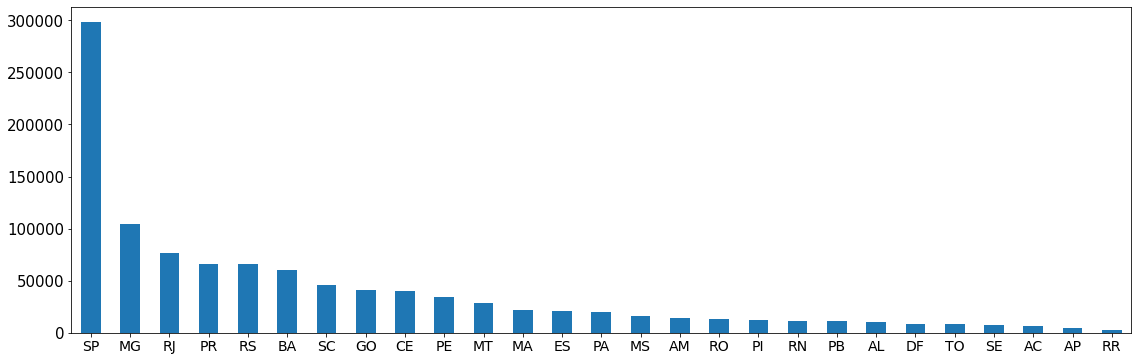

In [37]:
# Plotting registers per state

df.state.value_counts().plot(kind='bar', figsize=(19, 6))
plt.xticks(fontsize=14, rotation=0);
plt.yticks(fontsize=15);

### Taking only the top 3 of the states in the plot above...

In [38]:
df_se = df[df['state'].isin(['RJ', 'SP', 'MG'])]
rest_reg(df_se, 'gasoline dataframe in 2020 + 2019 + 2018 + 2017')

479166 registers in gasoline dataframe in 2020 + 2019 + 2018 + 2017.


In [39]:
df_se.head()

,region,state,city,shop,cnpj,product,date,price,buy_price,unit,flag
257759,SE,MG,ALFENAS,ALFA RVM LTDA,3418121000146,GASOLINA,01/05/2017,3.899,NaN,R$ / litro,BRANCA
257760,SE,MG,ALFENAS,ALFA RVM LTDA,3418121000146,GASOLINA,03/01/2017,3.950,3.37,R$ / litro,BRANCA
257761,SE,MG,ALFENAS,ALFA RVM LTDA,3418121000146,GASOLINA,03/04/2017,3.899,NaN,R$ / litro,BRANCA
257762,SE,MG,ALFENAS,ALFA RVM LTDA,3418121000146,GASOLINA,05/06/2017,3.799,NaN,R$ / litro,BRANCA
257763,SE,MG,ALFENAS,ALFA RVM LTDA,3418121000146,GASOLINA,06/02/2017,3.999,NaN,R$ / litro,BRANCA


In [40]:
# Counting NaN values

df_se.isna().sum()

region            0
state             0
city              0
shop              0
cnpj              0
product           0
date              0
price             0
buy_price    262355
unit              0
flag              0
dtype: int64

### A lot of NaN values in buy_price. It seems people don't like to tell how much they paid in the product they sell.

In [41]:
# Droping columns we don't need including the buy_price with a lot of NaN values

df_se.drop(['buy_price', 'unit'], axis=1, inplace=True)

/home/joaop/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [42]:
# Setting date column to datetime

df_se.date = pd.to_datetime(df_se.date, format='%d/%m/%Y')

/home/joaop/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [43]:
df_se.head()

,region,state,city,shop,cnpj,product,date,price,flag
257759,SE,MG,ALFENAS,ALFA RVM LTDA,3418121000146,GASOLINA,2017-05-01,3.899,BRANCA
257760,SE,MG,ALFENAS,ALFA RVM LTDA,3418121000146,GASOLINA,2017-01-03,3.950,BRANCA
257761,SE,MG,ALFENAS,ALFA RVM LTDA,3418121000146,GASOLINA,2017-04-03,3.899,BRANCA
257762,SE,MG,ALFENAS,ALFA RVM LTDA,3418121000146,GASOLINA,2017-06-05,3.799,BRANCA
257763,SE,MG,ALFENAS,ALFA RVM LTDA,3418121000146,GASOLINA,2017-02-06,3.999,BRANCA


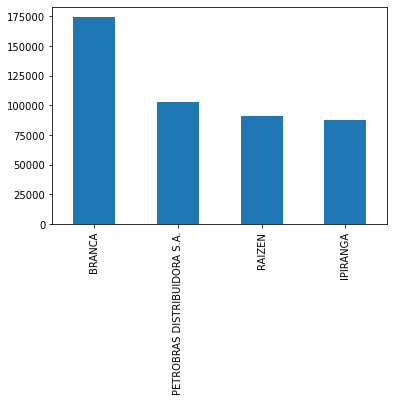

In [71]:
df_se.flag.value_counts().head(10).plot(kind='bar')

### I'm gonna consider only the top five flags, from "Branca" to "Ipiranga".

In [47]:
top_four = df_se.flag.value_counts().head(4).index

In [48]:
df_se = df_se.query('flag in @top_four')
rest_reg(df_se, 'top five flags in 2020 + 2019 + 2018 + 2017')

456990 registers in top five flags in 2020 + 2019 + 2018 + 2017.


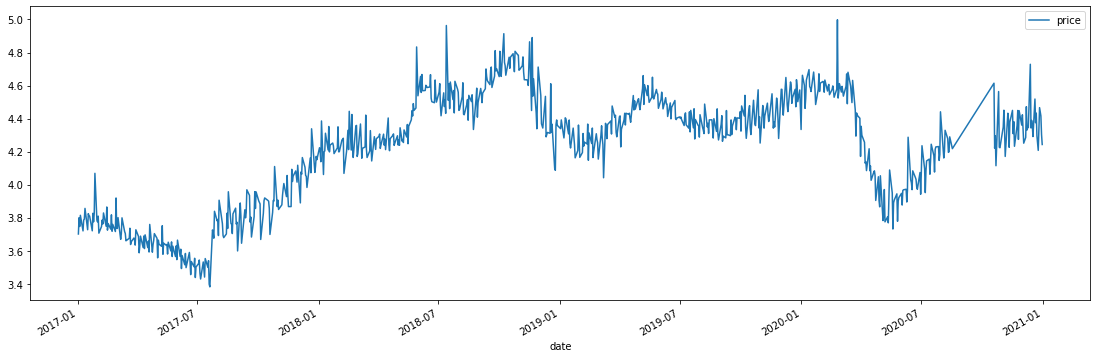

In [49]:
df_se.groupby('date').agg({'price': 'mean'}).plot(kind='line', figsize=(19,6))

### Notes:

 ####   - They didn't collect prices from september to half of october in 2020.
 ####   - Prices fell sharply during the beginning of pandemic.

### Merging gas prices in Brazil with USD/BRL and Crude WTI prices and Ethanol prices

In [50]:
exp_imp = exp_imp.reset_index().rename(columns={'index': 'date'})
exp_imp.head()

,date,hydr_eth_income,anid_eth_income,eth_hidr_exp,eth_anid_exp,gasoline_exp,gasoline_inc
0,2017-01-01,2167833.0,69372810.0,31680.0,85920169.0,115274214,25701417.0
1,2017-01-02,2167833.0,69372810.0,31680.0,85920169.0,115274214,25701417.0
2,2017-01-03,2167833.0,69372810.0,31680.0,85920169.0,115274214,25701417.0
3,2017-01-04,2167833.0,69372810.0,31680.0,85920169.0,115274214,25701417.0
4,2017-01-05,2167833.0,69372810.0,31680.0,85920169.0,115274214,25701417.0


In [51]:
df_se = df_se.merge(crude, how='left', on='date')

df_se = df_se.merge(dollar, how='left', on='date')

df_se = df_se.merge(ethanol, how='left', on='date')

df_se = df_se.merge(exp_imp, how='left', on='date')

df_se.head()

,region,state,city,shop,cnpj,product,date,price,flag,crude_price,usd_brl,ethanol_price,hydr_eth_income,anid_eth_income,eth_hidr_exp,eth_anid_exp,gasoline_exp,gasoline_inc
0,SE,MG,ALFENAS,ALFA RVM LTDA,3418121000146,GASOLINA,2017-05-01,3.899,BRANCA,48.84,3.1765,NaN,15224933.0,31270677.0,15596.0,123301519.0,112776335,2511466.0
1,SE,MG,ALFENAS,ALFA RVM LTDA,3418121000146,GASOLINA,2017-01-03,3.950,BRANCA,52.33,3.2652,1930.0,2167833.0,69372810.0,31680.0,85920169.0,115274214,25701417.0
2,SE,MG,ALFENAS,ALFA RVM LTDA,3418121000146,GASOLINA,2017-04-03,3.899,BRANCA,50.24,3.1147,1480.0,1794395.0,74131983.0,21568.0,55073312.0,159032884,4712751.0
3,SE,MG,ALFENAS,ALFA RVM LTDA,3418121000146,GASOLINA,2017-06-05,3.799,BRANCA,47.40,3.2969,1390.0,29505738.0,56636293.0,2890.0,98729069.0,1.82891e+08,5415021.0
4,SE,MG,ALFENAS,ALFA RVM LTDA,3418121000146,GASOLINA,2017-02-06,3.999,BRANCA,53.01,3.1160,1740.0,586030.0,42904259.0,6428.0,129522749.0,2.63418e+08,16256039.0


In [52]:
df_se.isna().sum()

region                 0
state                  0
city                   0
shop                   0
cnpj                   0
product                0
date                   0
price                  0
flag                   0
crude_price         1274
usd_brl              484
ethanol_price      90380
hydr_eth_income    49031
anid_eth_income    49031
eth_hidr_exp       49031
eth_anid_exp       49031
gasoline_exp       49031
gasoline_inc       49031
dtype: int64

    There are a lot of NaN values in crude_price and usd_brl.
    That's because we don't have trading floor working in weekends.
    
    And there are much more NaN values in ethanol prices because including lack of trading floors in the US market, we should also consider brazilian holidays. (And it looks a lot of gas prices have been collected on holidays).
    
    Therefore we should forward fill all NaN values, because in Saturday and Sunday, the price of crude and dollar can be considered the same as friday. The same happens in brazilian holidays.

In [53]:
df_se = df_se.sort_values(by='date')
df_se.ffill(inplace=True)

In [54]:
df_se.isna().sum()

region             0
state              0
city               0
shop               0
cnpj               0
product            0
date               0
price              0
flag               0
crude_price        0
usd_brl            0
ethanol_price      0
hydr_eth_income    0
anid_eth_income    0
eth_hidr_exp       0
eth_anid_exp       0
gasoline_exp       0
gasoline_inc       0
dtype: int64

### Now we have the dataframe complete, we should turn some categoric variables into dummies.

    - Gasolina and Gasolina Aditivada (a better gas).
    - Flags (the "brand" of the gas station).
    - City.

In [61]:
df_se.head(2)

,region,state,city,shop,cnpj,product,date,price,flag,crude_price,usd_brl,ethanol_price,hydr_eth_income,anid_eth_income,eth_hidr_exp,eth_anid_exp,gasoline_exp,gasoline_inc
9495,SE,MG,POUSO ALEGRE,AUTO POSTO PETROALEGRE LTDA,3887385000149,GASOLINA,2017-01-02,3.909,PETROBRAS DISTRIBUIDORA S.A.,54.03,3.2857,1925.0,2167833.0,69372810.0,31680.0,85920169.0,115274214,25701417.0
25311,SE,SP,ARARAQUARA,AUTO POSTO ARARAQUARA LTDA,43949742000170,GASOLINA,2017-01-02,3.530,BRANCA,54.03,3.2857,1925.0,2167833.0,69372810.0,31680.0,85920169.0,115274214,25701417.0


In [62]:
# Turning product into dummies, to treat all categorical variables in our dataframe.


df_final = df_se.copy()

for col in ['product', 'flag', 'city']:

    df_final = pd.concat([df_final, pd.get_dummies(df_final[col])], axis=1)
    df_final.drop([col], axis=1, inplace=True)

In [63]:
df_final = df_final[df_final.columns[4:]]
df_final.head()

,date,price,crude_price,usd_brl,ethanol_price,hydr_eth_income,anid_eth_income,eth_hidr_exp,eth_anid_exp,gasoline_exp,...,VALINHOS,VARGINHA,VARZEA PAULISTA,VASSOURAS,VESPASIANO,VICOSA,VINHEDO,VOLTA REDONDA,VOTORANTIM,VOTUPORANGA
9495,2017-01-02,3.909,54.03,3.2857,1925.0,2167833.0,69372810.0,31680.0,85920169.0,115274214,...,0,0,0,0,0,0,0,0,0,0
25311,2017-01-02,3.530,54.03,3.2857,1925.0,2167833.0,69372810.0,31680.0,85920169.0,115274214,...,0,0,0,0,0,0,0,0,0,0
6098,2017-01-02,3.990,54.03,3.2857,1925.0,2167833.0,69372810.0,31680.0,85920169.0,115274214,...,0,0,0,0,0,0,0,0,0,0
22864,2017-01-02,4.150,54.03,3.2857,1925.0,2167833.0,69372810.0,31680.0,85920169.0,115274214,...,0,0,0,0,0,0,0,0,0,0
9606,2017-01-02,3.780,54.03,3.2857,1925.0,2167833.0,69372810.0,31680.0,85920169.0,115274214,...,0,0,0,0,0,0,0,0,0,0


In [64]:
# Splitting the date into year, month and day variables.
# Adding day of week, weekday and also week in the year.

df_final['year'] = df_final['date'].dt.year
df_final['month'] = df_final['date'].dt.month
df_final['day'] = df_final['date'].dt.day
df_final['week'] = df_final['date'].dt.week
df_final['weekday'] = df_final['date'].dt.weekday

df_final['week_in_year'] = 0

for i in df_final.index:
    df_final.at[i, 'week_in_year'] = df_final.at[i, 'date'].isocalendar()[1]

df_final.drop('date', axis=1, inplace=True)

df_final.head()

,price,crude_price,usd_brl,ethanol_price,hydr_eth_income,anid_eth_income,eth_hidr_exp,eth_anid_exp,gasoline_exp,gasoline_inc,...,VINHEDO,VOLTA REDONDA,VOTORANTIM,VOTUPORANGA,year,month,day,week,weekday,week_in_year
9495,3.909,54.03,3.2857,1925.0,2167833.0,69372810.0,31680.0,85920169.0,115274214,25701417.0,...,0,0,0,0,2017,1,2,1,0,1
25311,3.530,54.03,3.2857,1925.0,2167833.0,69372810.0,31680.0,85920169.0,115274214,25701417.0,...,0,0,0,0,2017,1,2,1,0,1
6098,3.990,54.03,3.2857,1925.0,2167833.0,69372810.0,31680.0,85920169.0,115274214,25701417.0,...,0,0,0,0,2017,1,2,1,0,1
22864,4.150,54.03,3.2857,1925.0,2167833.0,69372810.0,31680.0,85920169.0,115274214,25701417.0,...,0,0,0,0,2017,1,2,1,0,1
9606,3.780,54.03,3.2857,1925.0,2167833.0,69372810.0,31680.0,85920169.0,115274214,25701417.0,...,0,0,0,0,2017,1,2,1,0,1


### Inserting the dataset in a model...

In [65]:
X = df_final[df_final.columns[1:]].values
y = df_final['price'].values

In [66]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [67]:
rf = RandomForestRegressor(criterion='mse')

In [68]:
%%time

rf.fit(X_train,y_train)

y_pred = rf.predict(X_test)

CPU times: user 21min 28s, sys: 175 ms, total: 21min 28s
Wall time: 21min 28s


In [69]:
acc = r2_score(y_test, y_pred)

In [70]:
acc

0.9188261568684312

In [72]:
from sklearn.model_selection import GridSearchCV

In [73]:
params = {'n_estimators': [50, 150], 
          'max_depth': [30, 50]}

In [74]:
%%time
grid = GridSearchCV(rf,
                    param_grid=params,
                    n_jobs=1,
                    cv=3,
                    verbose=3,
                    return_train_score = True)

grid.fit(X_train, y_train)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] max_depth=30, n_estimators=50 ...................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  max_depth=30, n_estimators=50, score=(train=0.781, test=0.760), total= 3.3min
[CV] max_depth=30, n_estimators=50 ...................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.4min remaining:    0.0s


[CV]  max_depth=30, n_estimators=50, score=(train=0.780, test=0.759), total= 3.3min
[CV] max_depth=30, n_estimators=50 ...................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  6.7min remaining:    0.0s


[CV]  max_depth=30, n_estimators=50, score=(train=0.778, test=0.759), total= 3.5min
[CV] max_depth=30, n_estimators=150 ..................................
[CV]  max_depth=30, n_estimators=150, score=(train=0.781, test=0.761), total=10.3min
[CV] max_depth=30, n_estimators=150 ..................................
[CV]  max_depth=30, n_estimators=150, score=(train=0.780, test=0.759), total=10.3min
[CV] max_depth=30, n_estimators=150 ..................................
[CV]  max_depth=30, n_estimators=150, score=(train=0.779, test=0.760), total=10.0min
[CV] max_depth=50, n_estimators=50 ...................................
[CV]  max_depth=50, n_estimators=50, score=(train=0.866, test=0.838), total= 4.3min
[CV] max_depth=50, n_estimators=50 ...................................
[CV]  max_depth=50, n_estimators=50, score=(train=0.865, test=0.836), total= 4.3min
[CV] max_depth=50, n_estimators=50 ...................................
[CV]  max_depth=50, n_estimators=50, score=(train=0.863, test=0.835

[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed: 93.9min finished


CPU times: user 1h 55min 7s, sys: 3.4 s, total: 1h 55min 11s
Wall time: 1h 55min 12s


GridSearchCV(cv=3, estimator=RandomForestRegressor(), n_jobs=1,
             param_grid={'max_depth': [30, 50], 'n_estimators': [50, 150]},
             return_train_score=True, verbose=3)

In [75]:
grid.best_params_

{'max_depth': 50, 'n_estimators': 150}

In [76]:
y_pred = grid.predict(X_test)

In [77]:
r2_score(y_test, y_pred)

0.8380101581168861

# Version 2 of this work is going to test other models and other categorical variables.